In [87]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
import torchmetrics
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from torch.utils.data import DataLoader, Dataset, Subset
from matplotlib import pyplot as plt
import os
from pathlib import Path
from PIL import Image

In [121]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []
        self.labels = []

        # Populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            self.image_files.extend(full_image_path)

        # Store tumor type in self.labels (0 = fused glands, 1 = micropapillary, 2 = solid)
        for img in self.image_files:
            slide_num = img.split("/")[3].split("_")[0]
            tissue_num = img.split("_")[-2]
            if slide_num == "SQ1631":
                if tissue_num == "s1":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1632":
                if tissue_num == "s4":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1633":
                if tissue_num == "s2":
                    self.labels.append(0)
                else:
                    self.labels.append(2)
            elif slide_num == "SQ1634":
                if tissue_num == "s2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1635":
                if tissue_num == "s3" or tissue_num == "s4":
                    self.labels.append(2)
                elif tissue_num == "s1":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
            else:
                if tissue_num == "s4":
                    self.labels.append(1)
                else:
                    self.labels.append(2)
                
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert('L')  # Convert to grayscale or 'RGB' if needed
        label = self.labels[idx]  # Get the corresponding label
        if self.transform:
            image = self.transform(image)

        return image, label  # Return both image and label

# Define transformations (if needed)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 pixels
    transforms.ToTensor(),           # Convert to tensor
])

# Create dataset and dataloader
folder_path = '../data/raw_img/'
dataset = CustomImageDataset(folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

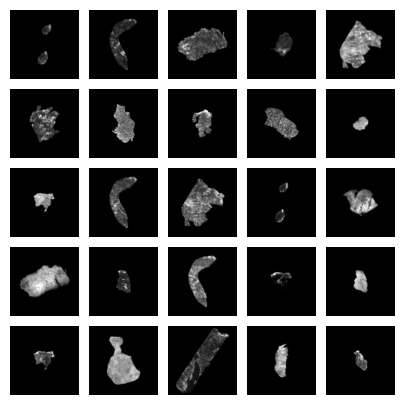

In [122]:
# Get a batch of 25 images for visualization
dataiter = iter(dataloader)
images, labels = next(dataiter)  # Unpack images and labels

num_samples = 25
sample_images = [images[i, 0].numpy() for i in range(num_samples)]  # Convert images to numpy

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')


In [123]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_shape=(1, 128, 128), latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder convolutional layers
        self.enc_conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)  # For grayscale input
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)

        # Calculate the flattened size after convolutions
        self.flattened_shape, self.flattened_size = self._get_flattened_size(input_shape)
        
        # Encoder fully connected layers
        self.enc_fc1 = nn.Linear(self.flattened_size, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        
        # Decoder fully connected layers
        self.dec_fc1 = nn.Linear(latent_dim, 128)
        self.dec_fc2 = nn.Linear(128, self.flattened_size)

        # Decoder convolutional layers
        self.dec_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_conv2 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

    def _get_flattened_size(self, input_shape):
        """Pass a dummy input through conv layers to determine the flattened size."""
        x = torch.zeros(1, *input_shape)  # Create a dummy input
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        flattened_shape = x.shape[1:]  # Save shape for reshaping in decoder
        flattened_size = x.numel()     # Total size after flattening
        return flattened_shape, flattened_size

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.enc_fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = F.relu(self.dec_fc1(z))
        x = F.relu(self.dec_fc2(x))
        x = x.view(-1, *self.flattened_shape)  # Dynamically reshape to match encoder output
        x = F.relu(self.dec_conv1(x))
        x = torch.sigmoid(self.dec_conv2(x))  # Output in [0, 1]
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [125]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (Binary Cross-Entropy)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL Divergence loss
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_div

Epoch 1/10, Loss: 85077.2489, Time: 130.29 sec
Epoch 2/10, Loss: 37782.6971, Time: 145.93 sec
Epoch 3/10, Loss: 37016.2245, Time: 150.29 sec
Epoch 4/10, Loss: 36722.1048, Time: 145.35 sec
Epoch 5/10, Loss: 36522.3161, Time: 145.20 sec
Epoch 6/10, Loss: 36381.6848, Time: 145.29 sec
Epoch 7/10, Loss: 36254.7944, Time: 145.54 sec
Epoch 8/10, Loss: 36165.3352, Time: 145.78 sec
Epoch 9/10, Loss: 36089.1616, Time: 145.71 sec
Epoch 10/10, Loss: 36047.2376, Time: 162.01 sec


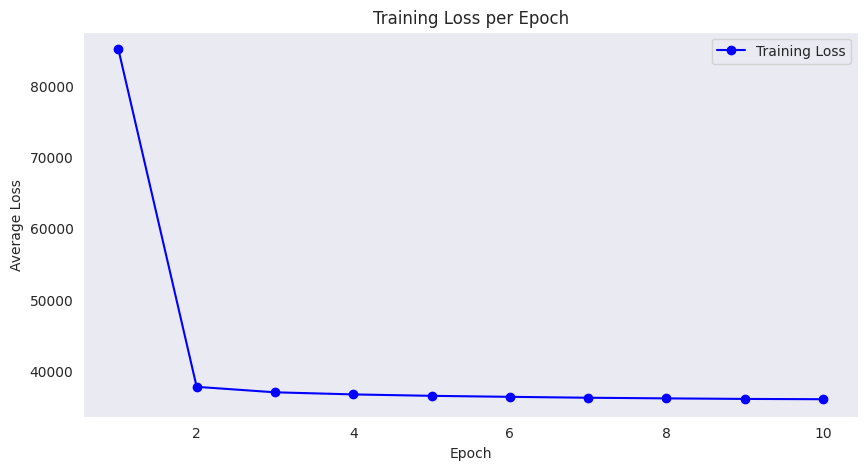

In [128]:
import torch.optim as optim
import time
import matplotlib.pyplot as plt

# Hyperparameters
latent_dim = 20
epochs = 10
learning_rate = 1e-3

# Model, optimizer, and device setup
device = torch.device("cpu")
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
training_loss = []
epoch_times = []

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    start_time = time.time()  # Start timer for epoch
    
    for images, labels in dataloader:  # Assuming dataloader is your DataLoader for the images
        images = images.to(device)
        
        # Forward pass
        recon_images, mu, logvar = model(images)
        
        # Compute loss
        loss = vae_loss(recon_images, images, mu, logvar)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    end_time = time.time()
    
    avg_loss = train_loss / len(dataloader)
    training_loss.append(avg_loss)
    
    # Calculate and store epoch duration
    epoch_duration = end_time - start_time
    epoch_times.append(epoch_duration)
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Time: {epoch_duration:.2f} sec")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), training_loss, marker='o', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid()
plt.show()


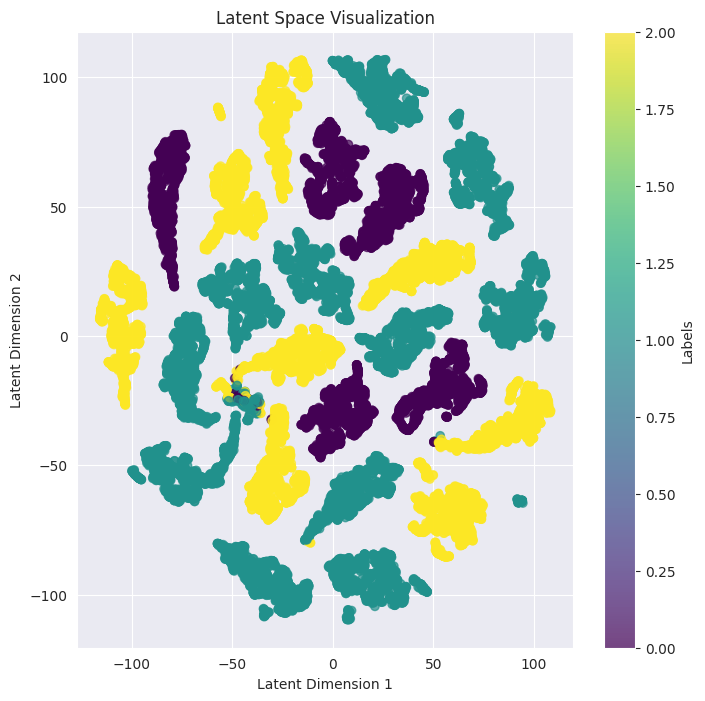

In [129]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch

def visualize_latent_space(model, dataloader, latent_dim=2, use_tsne=False):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(next(model.parameters()).device)
            mu, _ = model.encode(images)  # Only use the mean for visualization
            latents.append(mu.cpu())
            labels.append(label)

    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()

    if latent_dim > 2:
        if use_tsne:
            latents_2d = TSNE(n_components=2).fit_transform(latents)
        else:
            latents_2d = PCA(n_components=2).fit_transform(latents)
    else:
        latents_2d = latents  # If already 2D, no reduction needed

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap="viridis", alpha=0.7)
    plt.colorbar(scatter, label="Labels")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space Visualization")
    plt.show()

visualize_latent_space(model, dataloader, latent_dim=20, use_tsne=True)


In [135]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def get_latent_representations(model, dataloader):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(next(model.parameters()).device)
            mu, _ = model.encode(images)  # Only use mu as the latent representation
            latents.append(mu.cpu())
            labels.append(label)

    latents = torch.cat(latents)
    labels = torch.cat(labels)
    return latents, labels

latent_vectors, target_labels = get_latent_representations(model, dataloader)

latent_dim = latent_vectors.shape[1]
pseudo_image_shape = (1, int(latent_dim ** 0.5), int(latent_dim ** 0.5))  # Example: reshape into (1, 8, 8) if latent_dim is 64
latent_vectors = latent_vectors.view(-1, *pseudo_image_shape)

# Step 3: Prepare DataLoader for CNN
cnn_dataset = TensorDataset(latent_vectors, target_labels)
cnn_loader = DataLoader(cnn_dataset, batch_size=64, shuffle=True)

class CNNClassifier(nn.Module):
    def __init__(self, input_shape):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        # Calculate the flattened size after convolutions
        self.flattened_size = self._get_flattened_size(input_shape)

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 10)  # Assuming 10 classes; adjust based on your dataset

    def _get_flattened_size(self, input_shape):
        """Pass a dummy input through conv layers to determine the flattened size."""
        x = torch.zeros(1, *input_shape)  # Create a dummy input with input shape
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        return x.numel()  # Flattened size after convolutions and pooling

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Initialize and Train the CNN Classifier
cnn_model = CNNClassifier(input_shape=pseudo_image_shape).to(next(model.parameters()).device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0
    for batch_latents, batch_labels in cnn_loader:
        batch_latents, batch_labels = batch_latents.to(next(cnn_model.parameters()).device), batch_labels.to(next(cnn_model.parameters()).device)
        
        # Forward pass
        outputs = cnn_model(batch_latents)
        loss = criterion(outputs, batch_labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(cnn_loader):.4f}")

print("Training complete.")


AssertionError: Size mismatch between tensors

In [133]:
# Initialize and Train the CNN Classifier
cnn_model = CNNClassifier(input_shape=pseudo_image_shape).to(next(model.parameters()).device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0
    for batch_latents, batch_labels in cnn_loader:
        batch_latents, batch_labels = batch_latents.to(next(cnn_model.parameters()).device), batch_labels.to(next(cnn_model.parameters()).device)
        
        # Forward pass
        outputs = cnn_model(batch_latents)
        loss = criterion(outputs, batch_labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(cnn_loader):.4f}")

print("Training complete.")

NameError: name 'cnn_loader' is not defined

In [9]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import zarr
import numpy as np
sample_ls = ['SQ1631_s1_R', 'SQ1631_s2_R', 'SQ1631_s3_N', 'SQ1631_s4_N',
                 'SQ1632_s1_R', 'SQ1632_s2_N', 'SQ1632_s3_R', 'SQ1632_s4_N',
                 'SQ1633_s1_R', 'SQ1633_s2_R', 'SQ1633_s3_N', 'SQ1633_s4_N',
             'SQ1634_s1_N', 'SQ1634_s2_R', 'SQ1634_s3_R', 'SQ1634_s4_N',
             'SQ1635_s1_N', 'SQ1635_s2_R', 'SQ1635_s3_R', 'SQ1635_s4_N',
             'SQ1636_s1_R', 'SQ1636_s2_N', 'SQ1636_s3_N', 'SQ1636_s4_R']

tile_ls = []
label_ls = []

folder_path = '../data/zarr/'
for sample in sample_ls:
    zarr_path = f'{folder_path}/{sample}/slide.zarr'
    slide = zarr.open(zarr_path, mode='r')
    print(f'Zarr dataset loaded from {zarr_path}')
    tile_ls.append(slide)
    if sample.startswith("SQ1631"):
        if "s1" in sample:
            label_ls.append(0)
        else:
            label_ls.append(1)
    elif sample.startswith("SQ1632"):
        if "s4" in sample:
            label_ls.append(0)
        else:
            label_ls.append(1)
    elif sample.startswith("SQ1633"):
        if "s2" in sample:
            label_ls.append(0)
        else:
            label_ls.append(2)
    elif sample.startswith("SQ1634"):
        if "s2" in sample:
            label_ls.append(0)
        else:
            label_ls.append(1)
    elif sample.startswith("SQ1635"):
        if "s3" in sample or "s4" in sample:
            label_ls.append(2)
        elif "s1" in sample:
            label_ls.append(1)
        else:
            label_ls.append(0)
    else:
        if "s4" in sample:
            label_ls.append(1)
        else:
            label_ls.append(2)

Zarr dataset loaded from ../data/zarr//SQ1631_s1_R/slide.zarr
Zarr dataset loaded from ../data/zarr//SQ1631_s2_R/slide.zarr
Zarr dataset loaded from ../data/zarr//SQ1631_s3_N/slide.zarr
Zarr dataset loaded from ../data/zarr//SQ1631_s4_N/slide.zarr
Zarr dataset loaded from ../data/zarr//SQ1632_s1_R/slide.zarr
Zarr dataset loaded from ../data/zarr//SQ1632_s2_N/slide.zarr
Zarr dataset loaded from ../data/zarr//SQ1632_s3_R/slide.zarr
Zarr dataset loaded from ../data/zarr//SQ1632_s4_N/slide.zarr
Zarr dataset loaded from ../data/zarr//SQ1633_s1_R/slide.zarr
Zarr dataset loaded from ../data/zarr//SQ1633_s2_R/slide.zarr
Zarr dataset loaded from ../data/zarr//SQ1633_s3_N/slide.zarr
Zarr dataset loaded from ../data/zarr//SQ1633_s4_N/slide.zarr
Zarr dataset loaded from ../data/zarr//SQ1634_s1_N/slide.zarr
Zarr dataset loaded from ../data/zarr//SQ1634_s2_R/slide.zarr
Zarr dataset loaded from ../data/zarr//SQ1634_s3_R/slide.zarr
Zarr dataset loaded from ../data/zarr//SQ1634_s4_N/slide.zarr
Zarr dat

In [10]:
tile_ls = np.asarray(tile_ls)
print(tile_ls.shape)

(24, 917, 500, 500)


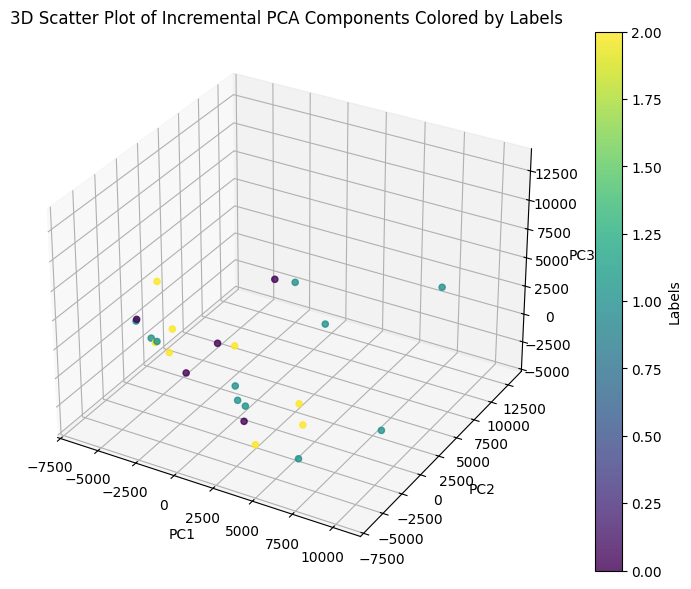

In [17]:
from sklearn.decomposition import IncrementalPCA
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Step 1: Mean pooling to reduce (24, 917, 500, 500) to (24, 500, 500)
mean_data = tile_ls.mean(axis=1)  # Shape: (24, 500, 500)

# Step 2: Reshape each (500, 500) to (250000,) for IncrementalPCA
reshaped_data = mean_data.reshape(24, -1)  # Shape: (24, 250000)

# Step 3: Apply Incremental PCA with n=3 components
n_components = 3
batch_size = 5  # Adjust based on available memory
ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)
pca_result = ipca.fit_transform(reshaped_data)  # Shape: (24, 3)

# Step 4: 3D Scatter Plot with color based on labels
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], 
                c=label_ls, cmap='viridis', alpha=0.8)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.colorbar(sc, ax=ax, label="Labels")
plt.title("3D Scatter Plot of Incremental PCA Components Colored by Labels")
plt.show()


ValueError: 'c' argument has 24 elements, which is inconsistent with 'x' and 'y' with size 22008.

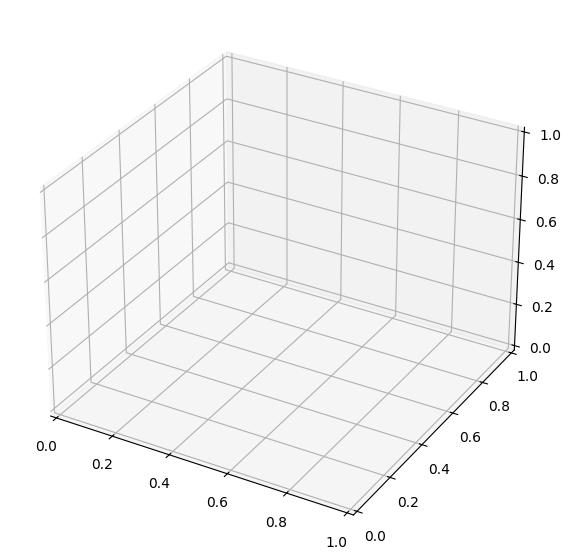

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
pca_result_flat = pca_result_reshaped.reshape(-1, 3)  # Shape: (22008, 3)
### 1. 3D Scatter Plot of the PCA components with color based on labels
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(pca_result_flat[:, 0], pca_result_flat[:, 1], pca_result_flat[:, 2], 
                c=label_ls, cmap='viridis', alpha=0.6)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.colorbar(sc, ax=ax, label="Labels")
plt.title("3D Scatter Plot of PCA Components Colored by Labels")
plt.show()